# Please open this notebook with Google Colab.
Colab will automatically prepare pytorch and GPU utility for you so that you don't need to install cuda and other related package again.

In this class activity, we will dig into facial expression recognition, a classic computer vision task, with pytorch. I've already implemented the dataset, baseline and evaluation script for you. Please go through the following notebook to get familiar with training and evaluation. After running the provided code and obtaining baseline result on the test set, please go to "Bonus point: Define a more complicated model" and implement your own code from there.

# Prepare Env and Dataset

In [1]:
!wget https://huggingface.co/datasets/Boese0601/CS535_2024spr/resolve/main/archive.zip

--2024-02-13 00:17:42--  https://huggingface.co/datasets/Boese0601/CS535_2024spr/resolve/main/archive.zip
Resolving huggingface.co (huggingface.co)... 18.172.134.124, 18.172.134.4, 18.172.134.88, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/8c/f8/8cf810f67a7acf502fb246b721100ca55e1086207178342d0cec0953ba0c6aa4/607ba8de794161b04002ff5bf1c50ca9cbc7e232c2abbd5fdc760aaa9f44b93b?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27archive.zip%3B+filename%3D%22archive.zip%22%3B&response-content-type=application%2Fzip&Expires=1708042662&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwODA0MjY2Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzhjL2Y4LzhjZjgxMGY2N2E3YWNmNTAyZmIyNDZiNzIxMTAwY2E1NWUxMDg2MjA3MTc4MzQyZDBjZWMwOTUzYmEwYzZhYTQvNjA3YmE4ZGU3OTQxNjFiMDQwMDJmZjViZjFjNTB

In [2]:
%ls

archive.zip  sample_data/


In [3]:
import zipfile
import os
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [4]:
%ls

fer20131.csv  fer2013.bib  ferSubmission.csv  README  sample_data/


In [5]:
!pip install mediapipe==0.9.0.1
!pip install evidently

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.1
    Uninstalling pydantic-2.6.1:
      Successfully uninstalled pydantic-2.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kalei

# Importing necessary libraries

In [18]:
# imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import make_grid

import mediapipe as mp

from tqdm.notebook import tqdm
tqdm.pandas()

In [7]:
dataset=pd.read_csv("fer20131.csv")

In [8]:
dataset["emotion"].value_counts(normalize=True)*100

3    25.048068
6    17.270878
4    16.933709
2    14.269791
0    13.801655
5    11.151671
1     1.524229
Name: emotion, dtype: float64

In [9]:
train_df = dataset[dataset["Usage"] == "Training"]
val_df = dataset[dataset["Usage"] == "PublicTest"]
test_df = dataset[dataset["Usage"] == "PrivateTest"]

# Converting into tensor-Dataset

In [10]:
class FER2018Dataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.classes = {0: 'Angry',
                        1: 'Disgust',
                        2: 'Fear',
                        3: 'Happy',
                        4: 'Sad',
                        5: 'Surprise',
                        6: 'Neutral'
                       }

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        label = int(row['emotion'])
        img = np.array(row["pixels"].split(' '), dtype=np.uint8).reshape(48, 48)
        img = np.stack([img] * 3, axis=2) # make a 3-channel RGB image from a grayscale


        if self.transform:
            img = self.transform(img)

        return {
                'image': torch.tensor(img, dtype=torch.float),
                'label': torch.tensor(label, dtype=torch.long)
            }

In [11]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip()
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = FER2018Dataset(train_df, train_transform)
val_dataset = FER2018Dataset(val_df, test_transform)
test_dataset = FER2018Dataset(test_df, test_transform)

In [12]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size, num_workers=1, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=1, pin_memory=True)

# Connect if Gpu is available

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
device

device(type='cuda')

In [15]:
!nvidia-smi

Tue Feb 13 00:19:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Visulization of Images

  0%|          | 0/7 [00:00<?, ?it/s]

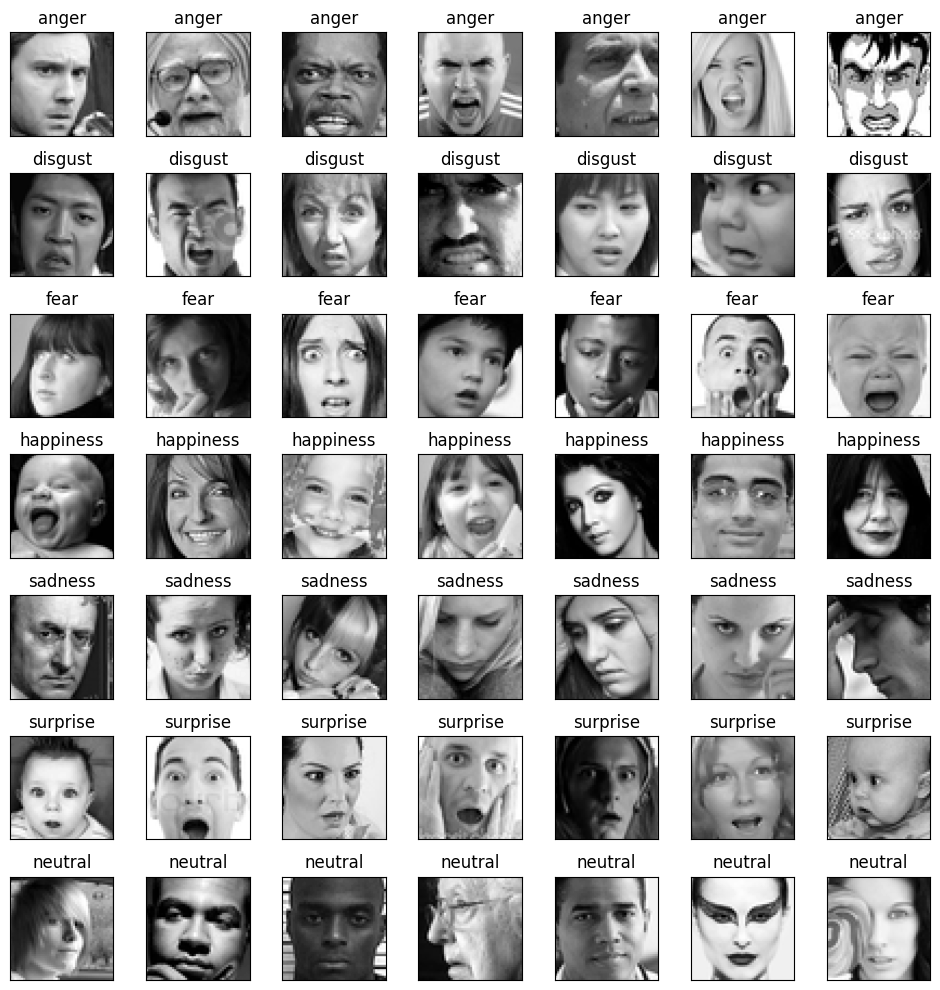

In [20]:
import cv2
fig = plt.figure(1, (10, 10))
k = 0
emotions = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
for label in tqdm(sorted(dataset.emotion.unique())):
    for j in range(7):
        px = dataset[dataset.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        px = cv2.resize(px, dsize=(192, 192), interpolation=cv2.INTER_NEAREST)
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

# Landmark Detection with MediaPipe

In [34]:
import cv2
def detect_mediapipe(image):
  mp_face_detection = mp.solutions.face_detection
  mp_face_mesh = mp.solutions.face_mesh
  # help(mp_face_detection.FaceDetection)


  mp_drawing = mp.solutions.drawing_utils
  drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
  mp_drawing_styles = mp.solutions.drawing_styles

  FACEMESH_LIPS = [(61, 146), (146, 91), (91, 181), (181, 84), (84, 17),
                            (17, 314), (314, 405), (405, 321), (321, 375),
                            (375, 291), (61, 185), (185, 40), (40, 39), (39, 37),
                            (37, 0), (0, 267),
                            (267, 269), (269, 270), (270, 409), (409, 291),
                            (78, 95), (95, 88), (88, 178), (178, 87), (87, 14),
                            (14, 317), (317, 402), (402, 318), (318, 324),
                            (324, 308), (78, 191), (191, 80), (80, 81), (81, 82),
                            (82, 13), (13, 312), (312, 311), (311, 310),
                            (310, 415), (415, 308)]
  FACEMESH_LEFT_EYE = [(263, 249), (249, 390), (390, 373), (373, 374),
                                (374, 380), (380, 381), (381, 382), (382, 362),
                                (263, 466), (466, 388), (388, 387), (387, 386),
                                (386, 385), (385, 384), (384, 398), (398, 362)]


  FACEMESH_RIGHT_EYE = [(33, 7), (7, 163), (163, 144), (144, 145),
                                  (145, 153), (153, 154), (154, 155), (155, 133),
                                  (33, 246), (246, 161), (161, 160), (160, 159),
                                  (159, 158), (158, 157), (157, 173), (173, 133)]
  Left_eye = []
  Right_eye = []
  Lips = []
  for (x,y) in FACEMESH_LEFT_EYE:
    if x not in Left_eye:
      Left_eye.append(x)
    if y not in Left_eye:
      Left_eye.append(y)
  # print(Left_eye)
  # print(FACEMESH_LEFT_EYE)

  for (x,y) in FACEMESH_RIGHT_EYE:
    if x not in Right_eye:
      Right_eye.append(x)
    if y not in Right_eye:
      Right_eye.append(y)
  # print(Right_eye)
  # print(FACEMESH_RIGHT_EYE)

  for (x,y) in FACEMESH_LIPS:
    if x not in Lips:
      Lips.append(x)
    if y not in Lips:
      Lips.append(y)
  # print(Lips)
  # print(FACEMESH_LIPS)


  with mp_face_mesh.FaceMesh(
      static_image_mode=True,
      refine_landmarks=True,
      max_num_faces=2,
      min_detection_confidence=0.5) as face_mesh:
      # Convert the Gray Scale image to RGB and process it with MediaPipe Face Mesh.
      image = cv2.resize(image, dsize=(192, 192), interpolation=cv2.INTER_NEAREST)
      results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
      if results == None:
        print("No Face deteced for this image.")
      # Draw face landmarks of each face.
      # print(f'Face landmarks of {name}:')
      if not results.multi_face_landmarks:
        print("No landmark deteced for this image.")
      annotated_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

      # print(len(results.multi_face_landmarks)) 1
      for face_landmarks in results.multi_face_landmarks:
          # print(face_landmarks)
          mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
          mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
          mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())

          lm_left_eye_x = []
          lm_left_eye_y = []
          lm_right_eye_x = []
          lm_right_eye_y = []
          lm_lips_x = []
          lm_lips_y = []
          for i in Left_eye:
            lm_left_eye_x.append(face_landmarks.landmark[i].x)
            lm_left_eye_y.append(face_landmarks.landmark[i].y)
          for i in Right_eye:
            lm_right_eye_x.append(face_landmarks.landmark[i].x)
            lm_right_eye_y.append(face_landmarks.landmark[i].y)
          for i in Lips:
            lm_lips_x.append(face_landmarks.landmark[i].x)
            lm_lips_y.append(face_landmarks.landmark[i].y)
          lm_x = lm_left_eye_x + lm_right_eye_x + lm_lips_x
          lm_y = lm_left_eye_y + lm_right_eye_y + lm_lips_y
          landmark = np.array([lm_x,lm_y]).T
          # np.save(land_path, landmark)



  return annotated_image, landmark




  0%|          | 0/7 [00:00<?, ?it/s]

No landmark deteced for this image.
No landmark deteced for this image.
No landmark deteced for this image.
No landmark deteced for this image.
No landmark deteced for this image.
No landmark deteced for this image.


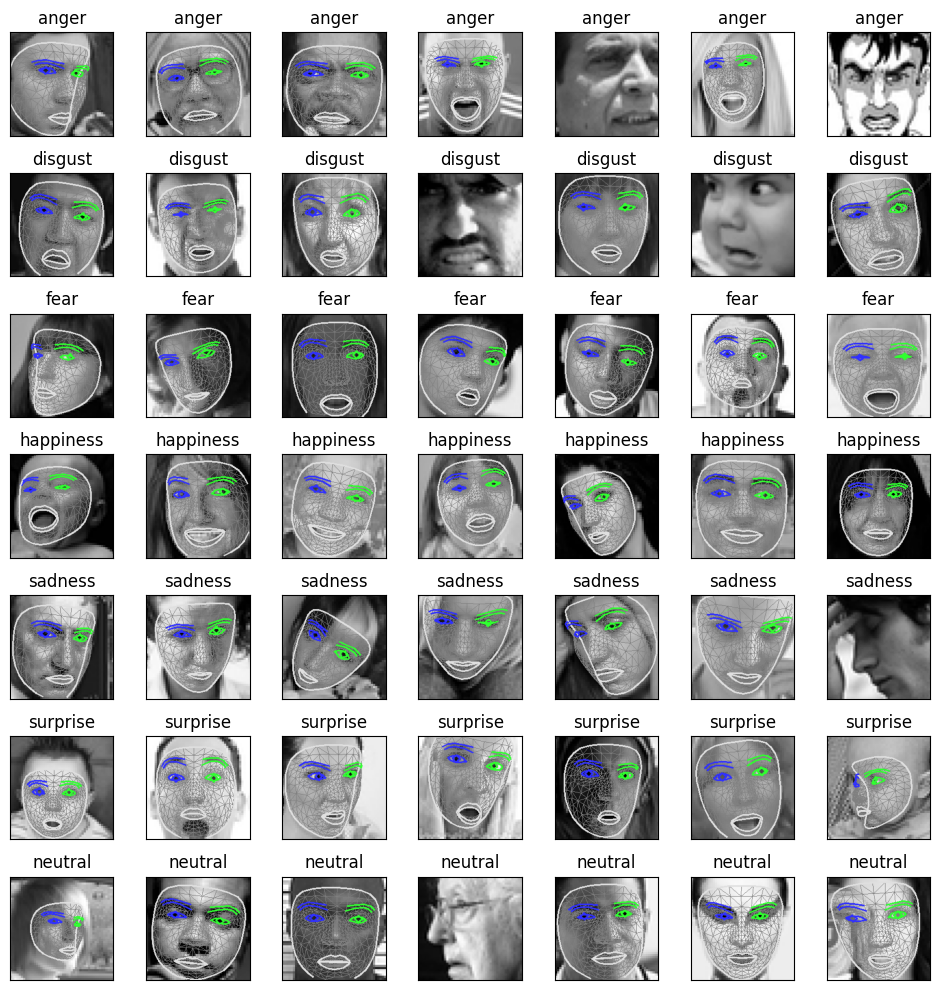

In [35]:
fig = plt.figure(1, (10, 10))
k = 0
emotions = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
for label in tqdm(sorted(dataset.emotion.unique())):
    for j in range(7):
        px = dataset[dataset.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48, 1).astype('uint8')
        # print(px.shape)
        try:
          px, _ = detect_mediapipe(px)
          k += 1
          ax = plt.subplot(7, 7, k)
          ax.imshow(px)
          ax.set_xticks([])
          ax.set_yticks([])
          ax.set_title(emotions[label])
          plt.tight_layout()
        except:
          px = px
          k += 1
          ax = plt.subplot(7, 7, k)
          ax.imshow(px,cmap="gray")
          ax.set_xticks([])
          ax.set_yticks([])
          ax.set_title(emotions[label])
          plt.tight_layout()

# Define Pytorch Model

In [24]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # load pretrained model
model.fc = nn.Linear(512, 7) # since we have 7 classes
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


# Bonus point: Define a more complicated model and retrain it
# Try to improve the performance on test set
# (Come back after you finish the baseline experiment with ResNet18)

Some other idea you may also consider for improving the result:

*   Apply Data Augmentation
*   Use detected landmark by mediapipe as extra input to the model




### Implement your model here

In [30]:
import torch
import torch.nn as nn
# model =
# model = model.to(device)

# Model Training

In [25]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0

    for data in tqdm(dataloader, desc="Training...", total=len(dataloader)):
        images, labels = data['image'].to("cuda"), data['label'].to("cuda")

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / len(dataloader)
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [26]:
# validation function
def validate(model, dataloader, optimizer, loss_fn):
    model.eval()

    valid_running_loss = 0.0
    vaild_running_acc = 0.0

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Validating...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            vaild_running_acc += accuracy(outputs.clone().detach(), labels)

    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = vaild_running_acc / len(dataloader)

    return valid_loss, valid_acc

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
# loss function and optimizer
epochs = 5
lr = 0.0005
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=5e-2, lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [29]:
# main loop
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(1, epochs + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    scheduler.step(val_epoch_loss)

    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())
    print(f'Epoch: {epoch},\
          Train loss: {train_epoch_loss:.4f},\
          Train acc: {train_epoch_acc:.4f},\
          Val loss: {val_epoch_loss:.4f},\
          Val acc: {val_epoch_acc:.4f}\
          ')
print('DONE TRAINING')

Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1,          Train loss: 1.4109,          Train acc: 0.4659,          Val loss: 1.2206,          Val acc: 0.5358          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2,          Train loss: 1.2202,          Train acc: 0.5403,          Val loss: 1.1453,          Val acc: 0.5630          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3,          Train loss: 1.1562,          Train acc: 0.5673,          Val loss: 1.1313,          Val acc: 0.5673          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 4,          Train loss: 1.1114,          Train acc: 0.5802,          Val loss: 1.1256,          Val acc: 0.5811          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 5,          Train loss: 1.0757,          Train acc: 0.5953,          Val loss: 1.1405,          Val acc: 0.5854          
DONE TRAINING


# Diagnostic plots

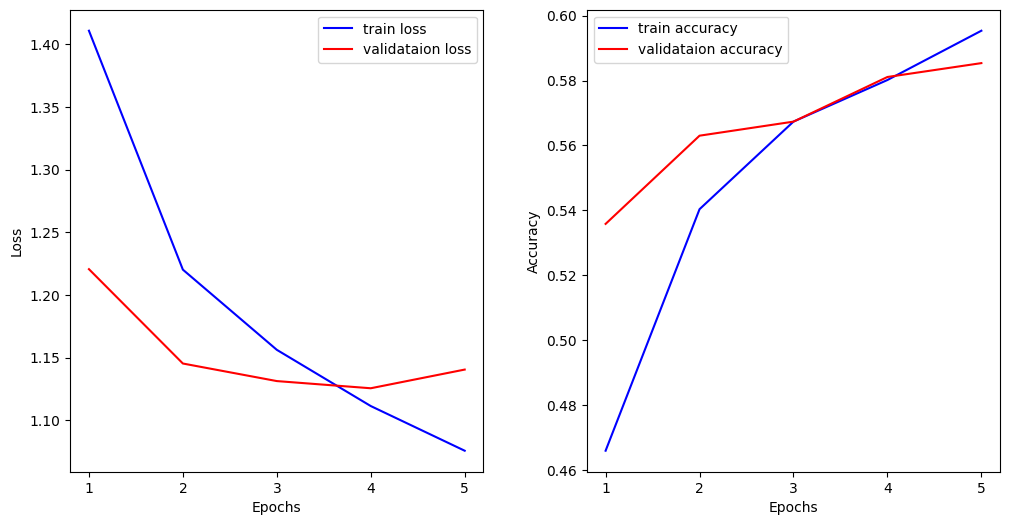

In [31]:
# loss plots
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.xticks(range(epochs), range(1, epochs + 1))
plt.ylabel('Loss')
plt.legend()


# accuracy plots
plt.subplot(122)
plt.plot(train_acc, color='blue', label='train accuracy')
plt.plot(val_acc, color='red', label='validataion accuracy')
plt.xlabel('Epochs')
plt.xticks(range(epochs), range(1, epochs + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.subplots_adjust(wspace=0.25)
plt.show()

In [32]:
classes = list(test_dataset.classes.values())
emotions = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
# test function
def test(model, dataloader):
    model.eval()

    # prepare to count predictions for each class
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)

            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            all_labels.extend(labels)
            all_predictions.extend(predictions)

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred, all_labels, all_predictions

correct_pred, total_pred, all_labels, all_predictions = test(model, test_dataloader)

Testing...:   0%|          | 0/57 [00:00<?, ?it/s]

# Results

In [33]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.4f}')

total_acc = sum(correct_pred[class_name] for class_name in classes) / len(test_dataset)
print(f"Total accuracy: {total_acc:.4f}")

Accuracy for class: Angry is 0.5906
Accuracy for class: Sad   is 0.4141
Accuracy for class: Happy is 0.9022
Accuracy for class: Neutral is 0.5655
Accuracy for class: Surprise is 0.7788
Accuracy for class: Fear  is 0.2235
Accuracy for class: Disgust is 0.1091
Total accuracy: 0.5938


# Results Monitoring

In [ ]:
try:
    import evidently
except:
    !pip install git+https://github.com/evidentlyai/evidently.git

In [ ]:
from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset
from evidently.tests import *

In [ ]:
test_df.rename(columns={"emotion":"target"},inplace=True)

In [ ]:
test_df["prediction"]=all_predictions

In [ ]:
from evidently import ColumnMapping

column_mapping = ColumnMapping()

column_mapping.target = test_df["target"]
column_mapping.prediction = test_df["prediction"]

In [ ]:
ref_data_sample = test_df[:1500]
prod_data_sample = test_df[1500:]

In [ ]:
#probabilistic binary classification
classification_report = Report(metrics=[
    ClassificationQualityMetric(),
    ClassificationClassBalance(),
    ConflictTargetMetric(),
    ConflictPredictionMetric(),
    ClassificationConfusionMatrix(),
    ClassificationQualityByClass(),
    ClassificationProbDistribution(),



])

classification_report.run(reference_data=ref_data_sample, current_data=prod_data_sample)
classification_report